# First pass at analyzing O2 dilution data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pboc.plotting
import sys
sys.path.insert(0, '../../../')
import mwc_growth as mwc
import tqdm
import pandas as pd
import matlab.engine as matlab
import scipy.optimize
import glob
import seaborn as sns
eng = matlab.start_matlab()
colors = pboc.plotting.set_plotting_style()
%matplotlib inline

## Calculating the calibration factor.

In [2]:

def cell_to_dict(file, eng, add_props=None, excluded_props=None):
    """
    Reads a single cell file and produces a dictionary containing
    the properties of interest.

    The returned properties are
    * birth - frame number at which the cell was born.
    * death - frame number at which the cell died.
    * divide - bool for an observed cell division.
    * ID - integer ID number of the cell.
    * motherID - integer ID number of the mother cell.
    * sisterID - integer ID number of the sister cell.
    * birth_fluo - fluorescence value at the cell's birth.
    * death_fluo - fluorescence value at the cell's death.
    * daughter_1_ID - integer ID number of the first daughter.
    * daughter_2_ID - integer ID number of the second daughter.


    Parameters
    ----------
    file: str
        Path of the cell file. This must be in a `.mat` format.
    eng: MATLAB engine object
        Engine of running matlab session.
    add_props : dict, default None
        Dictionary of additional properties (not found in the mat file)
        to be included in the returned dictionary.
    excluded_props: list of str
        Properties of cell.mat file to be ignored. These must be
        exactly how they are defined in the cell file.

    Returns
    -------
    cell_dict : dictionary
        Dictionary of all extracted properties from the cell files.
    """

    # Ensure the supplied file is actually a .mat and other types are correct.
    if file.split('.')[-1] != 'mat':
        raise TypeError("supplied file {0} is not a `.mat` file.".format(file))
    if add_props is not None and type(add_props) is not dict:
        raise TypeError(
            "add_props is {0} and not dict.".format(type(add_props)))
    if excluded_props is not None and type(excluded_props) is not list:
        raise TypeError(
            "add_props must be list. Type is currently {0}.".format(type(excluded_props)))

    # Define the values of interest.
    vals = ['birth', 'death', 'divide', 'ID', 'motherID', 'sisterID',
            'daughter_1_ID', 'daughter_2_ID', 'birth_fluo', 'death_fluo', 'birth_area', 'death_area']

    # Load the mat file using MATLAB.
    eng.workspace['f'] = file
    mat = eng.eval('load(f)')

    # Assemble the dictionary for constant properties.
    cell_dict = {v: mat[v] for v in vals[:-6]}
    daughters = np.array(mat['daughterID'])

    # Determine  if daughters were produced. If not, change ID to NaN.
    if len(daughters) == 0:
        daughter_1, daughter_2 = None,  None
    else:
        daughter_1, daughter_2 = daughters[0]
    cell_dict['daughter_1_ID'] = daughter_1
    cell_dict['daughter_2_ID'] = daughter_2

    # Extract fluorescence information -- This is a bit gross but checked.
    # Get number of fluorescence channels.
    fluo_channels = [f for f in mat['CellA'][0].keys() if 'fl' in f]
    n_channels = int(len(fluo_channels) / 3)
    for n in range(n_channels):
        _n = n + 1
        try:
            fluo = [mat['CellA'][i]['fl{0}'.format(
                _n)]['sum'] for i, _ in enumerate(mat['CellA'])]
            bg = [mat['CellA'][i]['fl{0}'.format(_n)]['bg'] for i, _ in enumerate(mat['CellA'])]
            nonzero = np.where(np.array(fluo) > 0)[0]
            num_exposures = len(nonzero)
            cell_dict['fluor{0}_bg_birth_fluo'.format(_n)] = bg[nonzero.min()]
            cell_dict['fluor{0}_bg_death_fluo'.format(_n)] = bg[nonzero.max()]
            cell_dict['fluor{0}_birth_fluo'.format(_n)] = fluo[nonzero.min()]
            cell_dict['fluor{0}_death_fluo'.format(_n)] = fluo[nonzero.max()]
            cell_dict['birth_area'] = mat['CellA'][nonzero.min()]['coord']['A']
            cell_dict['death_area'] = mat['CellA'][nonzero.max()]['coord']['A']
        except:
            cell_dict['fluor{0}_birth_fluo'.format(_n)] = 0
            cell_dict['fluor{0}_death_fluo'.format(_n)] = 0
            cell_dict['birth_area'] = mat['CellA'][0]['coord']['A']
            cell_dict['death_area'] = mat['CellA'][-1]['coord']['A']
            cell_dict['fluor{0}_bg_birth_fluo'.format(_n)] = 0
            cell_dict['fluor{0}_bg_death_fluo'.format(_n)] = 0
            num_exposures = 0
            cell_dict['fluor{0}_num_exposures'.format(_n)] = num_exposures

    # Deal with exclusion and addition of props.
    if excluded_props is not None:
        new_dict = {}
        keys = cell_dict.keys()
        for key in keys:
            if key not in excluded_props:
                new_dict[key] = cell_dict[key]
        cell_dict = new_dict
    if add_props is not None:
        for key in add_props.keys():
            cell_dict[key] = add_props[key]

    # Return the cell dictionary.
    return cell_dict


def parse_cell_files(files, eng, verbose=False, **kwargs):
    """
    Executes cell_to_dict across a list of files and returns a Pandas DataFrame.
    """
    if type(files) is not list:
        raise TypeError("'files' is type {0} not list.".format(type(files)))
    if verbose:
        files = tqdm.tqdm(files)
    for i, f in enumerate(files):
        cell_dict = cell_to_dict(f, eng, **kwargs)
        if i == 0:
            keys = cell_dict.keys()
            df = pd.DataFrame([], columns=keys)
            df = df.append(cell_dict, ignore_index=True)
        else:
            df = df.append(cell_dict, ignore_index=True)
    return df


In [3]:
# Define the data directory.
data_dir = '../../../data/images/20180123_37C_glucose_O2_dilution/'

# Grab the growth positions.
growth_pos = glob.glob('{0}20180123_growth*/xy*'.format(data_dir))

# Set up a list to store the resultant dataframes
dfs = []

# iterate through each position and load the cell files into python.
for i, pos in enumerate(growth_pos):
    
    # Load the cell files.
    cell_files = glob.glob('{0}/cell/*ell*.mat'.format(pos))
    
    # Parse each cell file and get a resulting dataframe.
    position = int(pos.split('/')[-1].split('xy')[1])
    _df = parse_cell_files(cell_files, eng=eng, add_props=dict(position=position),
                          verbose=True)
   
    # Append to the storage list.
    dfs.append(_df)
    
# Concatenate into a single data frame.
growth_df = pd.concat(dfs, ignore_index=True)

100%|██████████| 61/61 [00:03<00:00, 20.07it/s]


In [4]:
# Load the other data sets.
other_sets = glob.glob('{0}/*snaps*/'.format(data_dir))
desired_props = ['fluor1_birth_fluo', 'fluo2_birth_fluo', 'birth_area']
dfs = []
for i, samp in enumerate(other_sets):
        # Get the identity of the sample.
        _, _, strain, atc, _ = samp.split('/')[-2].split('_')
        atc = atc.split('ngmL')[0]
        
        # Get all of the positions in each folder.
        positions = glob.glob('{0}/xy*/'.format(samp))
    
        # Loop through each position.
        for j, pos in enumerate(positions):
            # Get a list of all cell files.
            cell_files = glob.glob('{0}/cell/*ell*.mat'.format(pos))
        
            # Parse them and exclude properties
            _df = parse_cell_files(cell_files, eng=eng, add_props=dict(position=j, strain=strain, atc=atc),
                                   verbose=True)
            dfs.append(_df)
         
snap_df = pd.concat(dfs, ignore_index=True)

100%|██████████| 33/33 [00:01<00:00, 20.86it/s]


In [5]:
# Find the mean autofluorescence value. 
auto_strain = snap_df[snap_df['strain']=='autofluorescence']
mean_auto_cherry = np.mean((auto_strain['fluor1_birth_fluo'] / auto_strain['birth_area']))
mean_auto_yfp = np.mean((auto_strain['fluor2_birth_fluo'] / auto_strain['birth_area']))

In [ ]:
mean_bg = growth_df['fluor1_bg_death_fluo'].mean()

Computing the triads is easier this time as we have just one snap at the end with a fluorescence image. 

In [ ]:
# Find the max frame.
max_frame = np.sort(growth_df['death'].unique())[-1]
measured = growth_df[(growth_df['death']==max_frame) & (growth_df['motherID']!=0)]

# Set the storage vectors.
I_1, I_2, summed, sq_diff = [], [], [], []

# Group the data by mother ID
grouped = measured.groupby(['position', 'motherID'])
for g, d in grouped:
    if len(d) == 2:
        daughters = d['fluor1_death_fluo'].values - d['death_area'].values * ( mean_bg + d['fluor1_bg_death_fluo'].values)
        if (daughters >= 0).all():
            I_1.append(daughters[0])
            I_2.append(daughters[1])
            summed.append(daughters.sum())
            sq_diff.append((daughters[0] - daughters[1])**2)

I_1 = np.array(I_1)
I_2 = np.array(I_2)
I_tot = I_1 + I_2

ratios = []
for i, j in zip(I_1, I_2):
    ratios.append(np.abs(i / (i + j)))
print(np.mean(ratios)) 



In [ ]:
x, y = np.sort(ratios), np.arange(len(ratios)) / len(ratios)
plt.vlines(np.mean(ratios), 0, 1.0, 'r')
plt.plot(x,y, '.')

In [8]:
bgs = growth_df['fluor1_bg_birth_fluo'].unique()
print(np.var(bgs) / np.mean(bgs))

0.552624865293


In [9]:
np.mean(bgs)

16.453628683057332

In [10]:
np.var(bgs)

9.0926843345567114

In [11]:
def deterministic_log_posterior(alpha, I_1, I_2, I_tot, neg=True):
    """
    Computes the log posterior of the deterministic solution to the estimation of the 
    calibration factor value.
    
    Parameters
    ----------
    alpha : float 
        The value of the calibration factor.
    I_1, I_2, I_tot : 1d-arrays or Pandas Series
        The intensity measurements of the daughter cells and the mother cell for a series of division events.
    neg : bool
        If True, the negative log posterior is returned. Default is True.
    
    Returns
    -------
    lp : float
        Value of the log posterior evaluated at the given value of alpha.
    """
    
    # Ensure that the intensity values are not negative.
    if (I_1 < 0).any() or (I_2 < 0).any():
        return -np.inf
    
    # Ensure that alpha is positive.
    if alpha < 0:
        return -np.inf
    
    # Compute the binomial coefficient.
    n_1 = I_1 / alpha
    n_2 = I_2 / alpha
    n_tot = I_tot / alpha
    binom = scipy.special.gammaln(n_tot+1).sum() - scipy.special.gammaln(n_1+1).sum() -\
            scipy.special.gammaln(n_2+1).sum()
 
    # Compute the log posterior.
    lp = -len(I_1) * np.log(alpha) + binom - n_tot.sum() * np.log(2)
    
    # Determine if the negative log posterior should be returned.
    if neg is True:
        prefactor = -1
    else: 
        prefactor = 1
        
    return prefactor * lp

In [12]:
import pymc3 as pm
import theano.tensor as tt
import pboc.mcmc


In [13]:
import imp
imp.reload(pboc.mcmc)

<module 'pboc.mcmc' from '/Users/gchure/Lab/PhillipsLab201401-XXX/lab_code/pboc-py/pboc/mcmc.py'>

In [17]:
class DeterministicLogPosterior(pm.Continuous):
    def __init__(self, int_1=None, int_2=None, *args, **kwargs):
        super(DeterministicLogPosterior, self).__init__(*args, **kwargs) 
    def logp(self, value, *args):
        n1 = I_1 / value
        n2 = I_2 / value
        ntot = n1 + n2
        k = len(I_1)
        binom = tt.sum(tt.gammaln(ntot+1)) - tt.sum(tt.gammaln(n1+1)) -tt.sum(tt.gammaln(n2+1))
        return -k * tt.log(value) + binom - tt.sum(ntot) * tt.log(2)

In [18]:
with pm.Model() as model:
    alpha = DeterministicLogPosterior('alpha', I_1, I_2, testval=100)
    trace = pm.sample(tune=5000, draws=5000, njobs=4)
    trace_df = pboc.mcmc.trace_to_dataframe(trace, model)
    stats = pboc.mcmc.compute_statistics(trace_df)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha]
100%|██████████| 10000/10000 [00:05<00:00, 1970.02it/s]
INFO (theano.gof.compilelock): Waiting for existing lock by process '97313' (I am process '97314')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/gchure/.theano/compiledir_Darwin-17.3.0-x86_64-i386-64bit-i386-3.6.4-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '97313' (I am process '97315')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/gchure/.theano/compiledir_Darwin-17.3.0-x86_64-i386-64bit-i386-3.6.4-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '97314' (I am process '97315')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/gchure/.theano/compiledir_Darwin-17.3.0-x86_64-i386-64bit-i386-3.6.4-64/lock_dir


In [19]:
alpha_opt = stats['mode']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c250f49e8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1c252707b8>]], dtype=object)

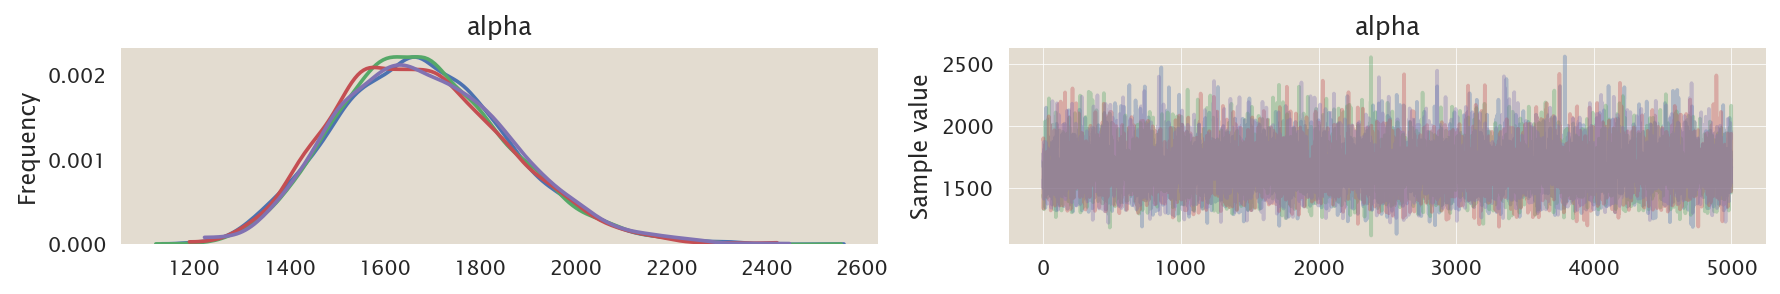

In [20]:
pm.traceplot(trace)

In [21]:
# Evaluate the posterior over a range of alpha.
alpha_range = np.logspace(0, 12, 500)
log_post = np.zeros_like(alpha_range)
for i, a in enumerate(alpha_range):
    lp = deterministic_log_posterior(a, brewster_df['I_1'], brewster_df['I_2'], 
                                     brewster_df['I_1'] + brewster_df['I_2'], neg=False)
    log_post[i] = lp
    
# Normalize the log posterior
log_post += np.abs(np.min(log_post)) 
log_post = log_post / 1E3
log_post = np.exp(log_post) / np.exp(log_post).sum()   

NameError: name 'brewster_df' is not defined

In [22]:
# Bin the data for plotting.
def binning_mean(data, bin_width, sort_values=False):
    """
    Computes the mean value of squared difference and summed intensity of the 
    supplied data with a given number of events per bin. 
    
    Parameters
    ----------
    data : pandas DataFrame
        A dataframe containing the intensities of the daughter cells and the sum
        total intensity.
    bin_width : int
        Number of events to consider per bin.
    sort_values : bool
        If True, the supplied data will be sorted in increasing order of the 
        sum total fluorescence. Default is False.
        
    Returns
    -------
    mean_sq_diff, mean_sum : 1d-arrays
        Arrays of the mean square difference value and the mean summed intensity 
        in a given bin width.  
    """
    # Sort the data if necessary.
    if sort_values:
        data = data.sort_values(by='I_tot')
        
    # Set the bins. 
    bins = np.arange(0, len(data) + bin_width, bin_width)
    
    # Compute the means. 
    mean_sq_diff = [np.mean((data.iloc[bins[i-1]:bins[i]+1]['I_1'] -\
                         data.iloc[bins[i-1]:bins[i]+1]['I_2'])**2) for i in range(1, len(bins))]
    mean_I_tot = [data.iloc[bins[i-1]:bins[i]+1]['I_tot'].mean() for i in range(1, len(bins))] 
    return [np.array(mean_sq_diff), np.array(mean_I_tot)] 

In [23]:
# Set up the data frame.
binning_df = pd.DataFrame(np.array([I_1, I_2, I_tot]).T, columns=['I_1', 'I_2', 'I_tot'])

# Bin the data. 
bin_size =  50 
mean_sq_diff, mean_I_tot = binning_mean(binning_df, bin_width=bin_size, sort_values=True)

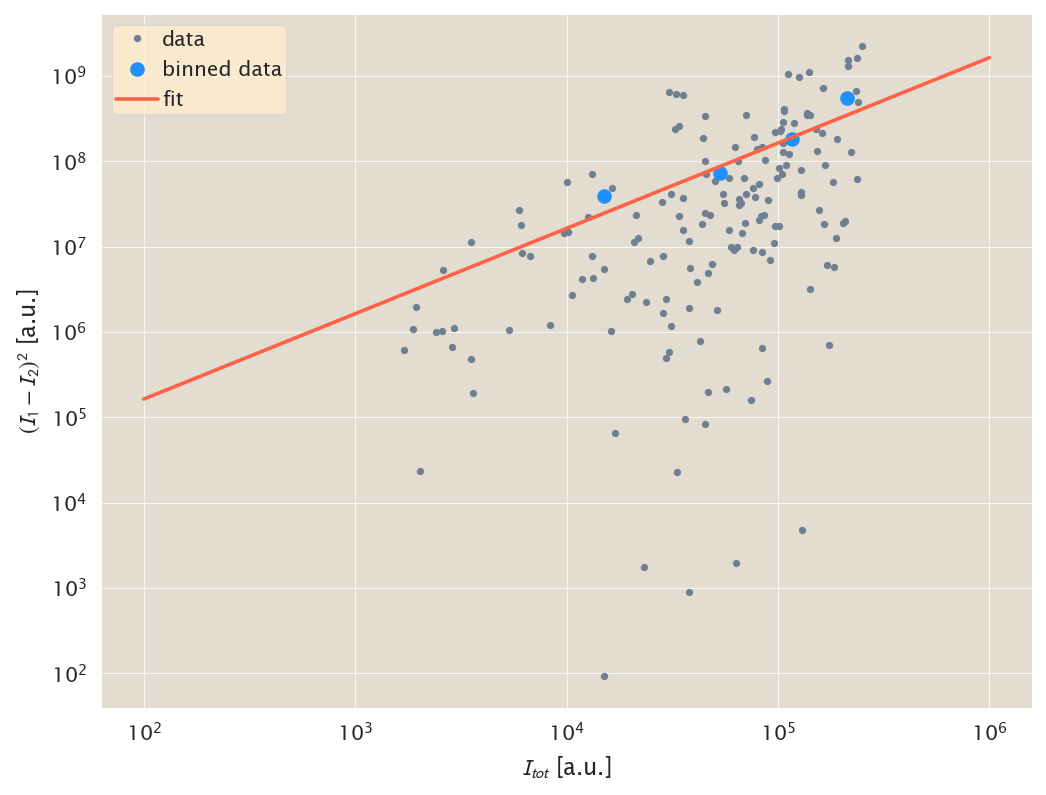

In [24]:
# Make the scatter plot.
fig, ax = plt.subplots(1, 1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$I_{tot}$ [a.u.]')
ax.set_ylabel('$(I_1 - I_2)^2$ [a.u.]')

# Plot the data
_ = ax.plot(summed, sq_diff, '.', color='slategray', label='data')

# Plot the binned data.
_ = ax.plot(mean_I_tot, mean_sq_diff, 'o', color='dodgerblue', label='binned data')

# Plot the theory curve. 
alpha_opt = stats['mode'].values
I_tot_range = np.logspace(2,6, 500)
theo = alpha_opt * I_tot_range
_ = ax.plot(I_tot_range, theo, '-', color='tomato', label='fit')

_ = ax.legend()

### Fit by binning 

Try fitting the calibration factor using the binning approach.  

In [60]:
def log_posterior(alpha, sq_diff, summed_int, neg=True):
    """
    Computes the log posterior distribution for linear regression.
    
    Parameters
    ----------
    alpha : float
        Value of the calibration factor in arbitrary units.
    I_tot : pandas DataFrame or array
        The summed value of the daughter intensities.
    neg: bool
        If True, the negative of the log posterior is returned. Defaults is True. 
    Returns
    --------
    lp : 1d-array
        The value of the log posterior at a given alpha. 

    """
    k = len(summed_int)
    lp = -(k/2) * np.log(np.sum((sq_diff - alpha * summed_int)**2))
    if neg is True:
        prefactor = -1
    else:
        prefactor = 1
    return prefactor * lp

## Testing the calibration factor. 

In [68]:
eng.workspace['f'] = '/Users/gchure/Desktop/dilution_data.mat'
mat = eng.eval('load(f)')

In [69]:
dif = mat['rdif']
tot = mat['rtot']
I2 = (tot - np.sqrt(dif)) / 2
I1 = np.sqrt(dif) + I2
I1 = I1[0]
I2 = I2[0]
popt = scipy.optimize.minimize_scalar(deterministic_log_posterior, args=(I1, I2, I1+I2, True))
brewster_df = pd.DataFrame(np.array([I1, I2, I1+I2]).T, columns=['I_1', 'I_2', 'I_tot'])

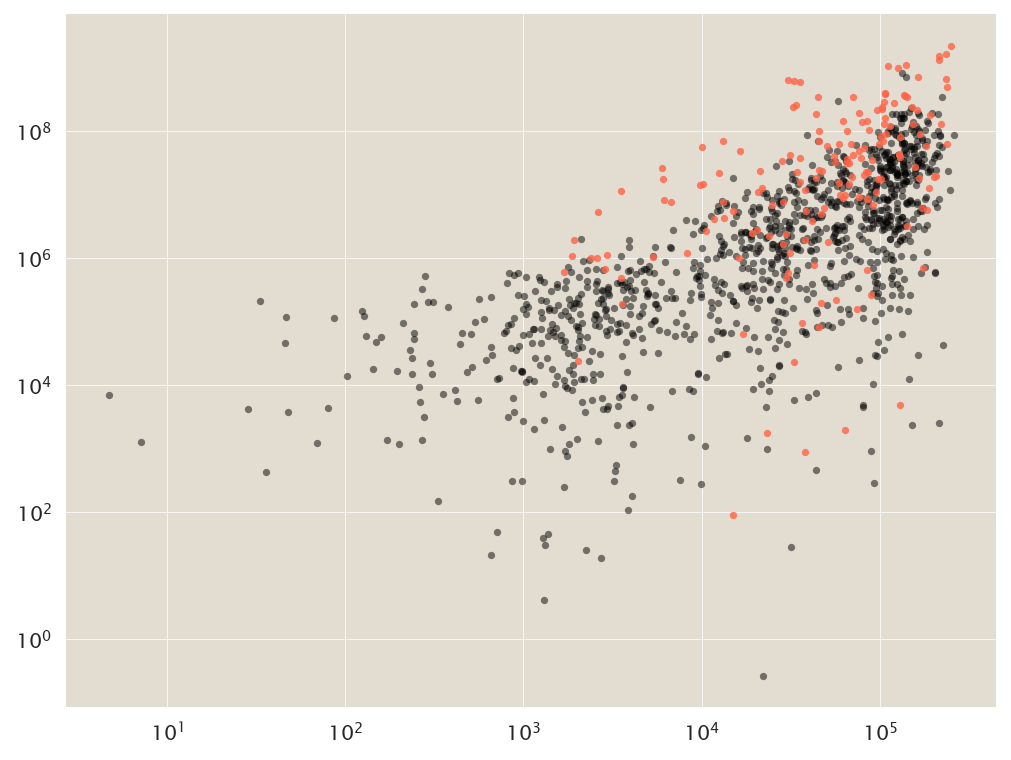

In [63]:
fig, ax = plt.subplots(1, 1)
ax.set_xscale('log')
ax.set_yscale('log')
_ = ax.plot(brewster_df['I_tot'], (brewster_df['I_1'] - brewster_df['I_2'])**2, 'k.', alpha=0.5)
_ = ax.plot(I_1 + I_2, (I_1 - I_2)**2, '.', color='tomato', alpha=0.8)

In [64]:
def ecdf(data):
    return np.sort(data), np.arange(0, len(data), 1) / len(data)

In [65]:
snap_df_small = snap_df

# Subtract the autofluorescence from each channel.
snap_df_small.loc[:, 'fluor2_sub'] = snap_df_small['fluor2_birth_fluo'] - snap_df_small['birth_area'] * mean_auto_yfp 
snap_df_small.loc[:, 'fluor1_sub'] = snap_df_small['fluor1_birth_fluo'] - snap_df_small['birth_area'] * mean_auto_cherry

# Compute the mean delta for each.
mean_delta_yfp = np.mean(snap_df_small[snap_df_small['strain']=='deltaLacI']['fluor2_sub'] / snap_df_small[snap_df_small['strain']=='deltaLacI']['birth_area'])
mean_delta_cherry = np.mean(snap_df_small[snap_df_small['strain']=='deltaTetR']['fluor1_sub'] / snap_df_small[snap_df_small['strain']=='deltaTetR']['birth_area'])

# Look at only the dilution strain and calculate the fold change.
dilution_strain = snap_df_small[snap_df_small['strain']=='dilution']
fold_change = []
repressors = []
grouped = dilution_strain.groupby('atc')
for g, d in grouped:
    mean_yfp = np.mean(d['fluor2_sub'] / d['birth_area'])
    fold_change.append(mean_yfp / mean_delta_yfp)
    mean_repressors = np.mean(d['fluor1_sub']) / alpha_opt
    repressors.append(mean_repressors)

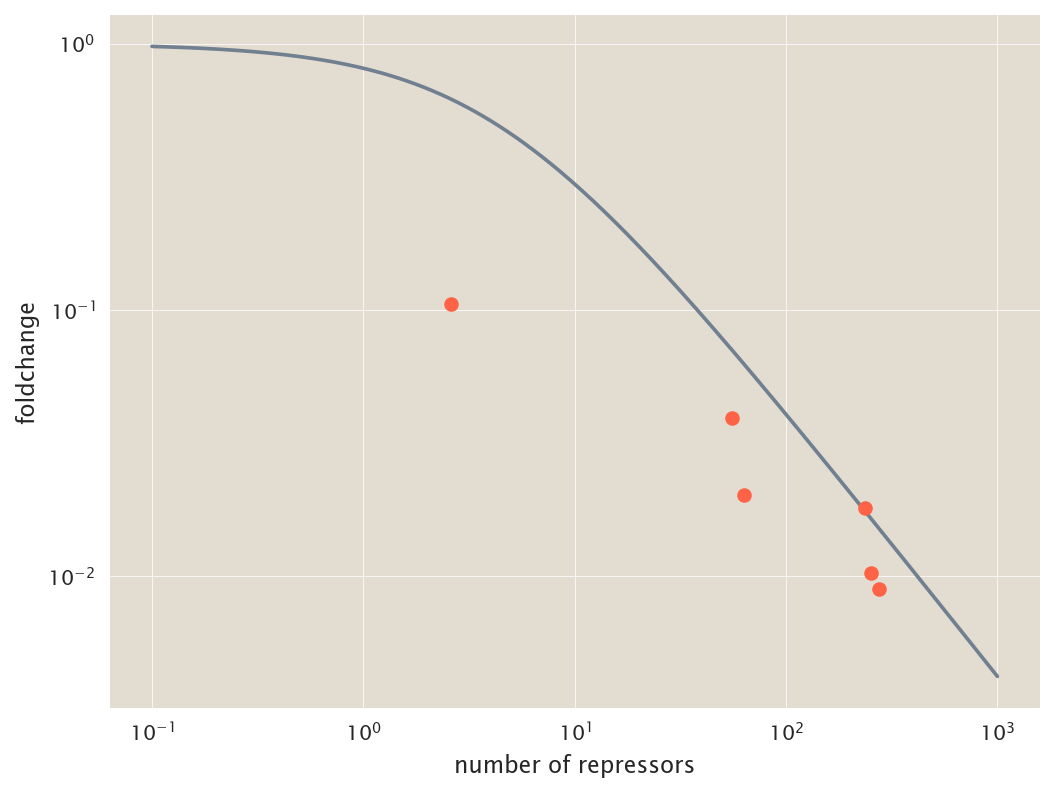

In [66]:
# Compute the prediction.
rep_range = np.logspace(-1, 3, 300)
fc_theo = (1 +  (rep_range / 4.6E6) * np.exp(13.9))**-1

# Generate the plot
fig, ax = plt.subplots(1, 1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('number of repressors')
ax.set_ylabel('foldchange')
all_fc = dilution_strain['fluor2_sub'] / mean_delta_yfp
all_rep = dilution_strain['fluor1_sub'] / alpha_opt
# Plot the prediction.
_ = ax.plot(rep_range, fc_theo, color='slategray', label='theory')

# Plot the data
_ = ax.plot(6 * np.array(repressors), fold_change, 'o', color='tomato', label='data')
# _ = ax.plot(all_rep, all_fc, ',', color='dodgerblue')
